# An Accurate Calculation of Over-by-Over odds of winning an IPL Cricket Match

## Overview

###### Often the Odds for a Cricket Team to win a match are swayed by the consensus of the general populus. This results in inaccurate and highly variable match predictions(odds calculations) often caused by speclators and spot-betters. 

We aim to build a model that will help us identify, in most cases, the outcome of an IPL Match so that we can stay ahead of the curve and remain unfazed by the randomness of the match. 

### We have selected a very special match to infer from in the history of IPL from this dataset. It is the 2017 IPL finals between Mumbai Indians and Rising Pune Super-Giants

While Mumbai posed a paltry 129/8 in 20 Overs, they somehow managed to snatch the win out of Rising Pune's mouths as Pune went on to lose 3 wickets in the last over and failed to score 11 runs to win the match, 10 to draw, scoring only 9 and thereby losing by 1 single run. 

We have taken our dataset from Kaggle Link: https://www.kaggle.com/manasgarg/ipl

This data set contains 2 csv sheets. One is the Ball-by-Ball Data and another is the overall outcome of a match. We combine both these data to create an over-by-over data with outcome of the match while adding several more features like required run-rate, current runrate, total wickets that fell in a single over to arrive to our inferences. 

We train our Machine Learning Model with all the Over-by-Over data of all the matches in IPL. Assuming that all IPL teams start off on the same footing with equal budgets and such, each team must have some special team players like Pinch Hitters, Death-Over Specialist in Batting as well as fielding, all-rounders who come at 8 down or 9 down and still possess enough quality to win you a match. 

Importing All the Relevant Package in one cell:

In [1]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)



Importing Ball By Ball Data and Match Outcome Data

In [2]:
deliveries_df = pd.read_csv("deliveries.csv")
matches_df = pd.read_csv("matches.csv")

In [3]:
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [4]:
matches_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


As mentioned above, since we are analysing for a particular season, we will take the matches taking place in **2017** only into consideration. 

Also, since anomalies like D/L methods are highly irregular and random in nature and also dependent on external factors like rain, umpire's call etc, we clean those data out of our dataset. 

In [5]:
# Let us take only the matches played in 2017 for this analysis #
matches_df = matches_df.loc[matches_df.season==2017,:]
matches_df = matches_df.loc[matches_df.dl_applied == 0,:]
matches_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Now that we are done with Data Cleaning, we can now create certain variables(stats) which will be helpful while inferring from our data. 

Some of the important variables which I could think of are the following:

1. Total runs scored by each team

2. Total wickets remaining/total wickets fallen

3. Runs required/to be chased 

4. Total target the team is chasing

5. Run Rate

6. Required Run Rate

7. Runs scored in last over

8. Wickets taken in last over

9. Difference between current run rate and required run rate

10. Binary variable representing the team for which we are predicting the win probability.

There are variables which can be created like:

1. Name of the Team

2. Name of the Opponent Team

3. Runs scored by the batting team in the last 'n' overs

4. Batsman

5. Bowler

However, we figured, while analysing for a team, minute interactions between two players does not matter much and usually the better team always wins. 


In [6]:
# runs and wickets per over #
deliveries_df = pd.merge(deliveries_df, matches_df[['id','season', 'winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
deliveries_df.player_dismissed.fillna(0, inplace=True)
deliveries_df['player_dismissed'].loc[deliveries_df['player_dismissed'] != 0] = 1
train_df = deliveries_df.groupby(['match_id', 'inning', 'over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

In [7]:
# innings score and wickets #
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42


In [8]:
# Get the target column #
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.ix[temp_df['inning']==1,:]
temp_df['inning'] = 2
# temp_df
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)
train_df.head()

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7,-1.0
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23,-1.0
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29,-1.0
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33,-1.0
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42,-1.0


In [9]:
# get the remaining target #
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

In [10]:
# get the run rate #
train_df['run_rate'] = train_df['innings_score'] / train_df['over']


In [11]:
# get the remaining run rate #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    else:
        return row['remaining_target'] / (21-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

In [12]:
train_df.head()

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,1
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000,-1.0,-1.0,1,1
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667,-1.0,-1.0,1,1
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000,-1.0,-1.0,1,1
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000,-1.0,-1.0,1,1


Now let us split the data and keep the final match as our validation sample.

In [13]:
x_cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

# let us take all the matches but for the final as development sample and final as val sample #
final_df = train_df.ix[train_df.match_id == 59,:]
model_df = train_df.ix[train_df.match_id != 59,:]
final_df.head()

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2185,59,1,1,Mumbai Indians,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,3,0,0,3,-1.0,-1.0,3.00,-1.0,-1.0,1,1
2186,59,1,2,Mumbai Indians,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,4,0,0,7,-1.0,-1.0,3.50,-1.0,-1.0,1,1
2187,59,1,3,Mumbai Indians,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,2,2,2,9,-1.0,-1.0,3.00,-1.0,-1.0,1,1
2188,59,1,4,Mumbai Indians,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,2,0,2,11,-1.0,-1.0,2.75,-1.0,-1.0,1,1
2189,59,1,5,Mumbai Indians,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,5,0,2,16,-1.0,-1.0,3.20,-1.0,-1.0,1,1


In [14]:
# create the input and target variables #
model_X = np.array(model_df[x_cols[:]])
model_y = np.array(model_df['target'])
final_X = np.array(final_df[x_cols[:]])[:,:]
final_y = np.array(final_df['target'])[:]
print(model_X.shape, model_y.shape)
print(final_X.shape, final_y.shape)

(2185, 12) (2185,)
(40, 12) (40,)


We are using Extra Trees Regressor from the Sci-Kit Learn Ensemble. We create a function for the same and run it. 

The Reason for us using Extra Trees Regressor stems through the primary characteristics of our data. We explored some more classifiers but could not generate good results because of the following reasons: 
1. k-Nearest Neighbours is rote learner and a lazy classifier such sort of classifiers work for small amount of data however fail for the large volume of features (classes) and data. Also, k-NN is very sensitive to noise.
2. Support Vector Machine based Regressors didn't lend ideal results for our project because intrinsically, SVMs are good for 2-dimensional i.e 2 class data. When we increase the dimensionality of the feature set, it becomes difficult for the machine to compute good values and it becomes tough for us to visualize the working of SVM past 3 dimensions. Whilst it's quite known that Tree based algorithm usually do better than SVMs in structured data. 
3. Logistic Regression, similar to SVM has computational problems with multi-class data(features>2) but it lended results better than k-NN since it functions a bit better at handling noise/outliers and less usefull features. 
4. We finally arrived to Tree based algorithms and Ensemble based learners and we had 2 more options: 
    
 4.1 Gradient Boosting Trees: Gradient Boosting Trees are good classifiers, however they use averaging from their decision(regression trees) rather than the Bootstrap and Bias method used by Random Forest and Random Forest Based Classifiers. This results in them filtering out all the outliers better than Random Forest. However, we, in IPL Data require more sensitivity towards outliers since some of the exciting nail-bitimg matches are decided in death overs and while boosting dictates to declare this as an outlier, we know that matches like IPL Finals should ideally belong to such outliers, being a competition between 2 very good teams. 
    
 4.2 Random Forest Classifiers: Within Random Forest Classifiers and Regressors, which uses Decision Trees is good enough as such, however Extra Trees was better because it uses an aggregation algorithm for its Decision Trees which is even more better and less biased to outliers than Random Forests. Random Forest assigns a default bias to poorly performing Decision Trees(also known as weak learners), however, Extra Trees uses feature selection on a case-by-case randomized basis instead of Random Forest's bias based selection process. This, being more robust and more sensitive to outliers performs the best for our project. 

In [15]:
# define the function to create the model #
def ETRegr(train_X, train_y, seed_val=0):
    clf = ExtraTreesRegressor(n_estimators = 15, criterion='mae',min_samples_split=2)
    model = clf.fit(train_X,train_y)
    return model

We now are all set to build our predictive model. 

In [16]:
model = ETRegr(model_X, model_y)
preds = model.predict(final_X)

In [17]:
out_df = pd.DataFrame({'Team1':final_df.team1.values})
out_df['is_batting_team'] = final_df.is_batting_team.values
out_df['innings_over'] = np.array(final_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = final_df.innings_score.values
out_df['innings_wickets'] = final_df.innings_wickets.values
out_df['score_target'] = final_df.score_target.values
out_df['total_runs'] = final_df.total_runs.values
out_df['player_dismissed'] = final_df.player_dismissed.values
out_df['run_rate'] = final_df.run_rate.values
out_df['runrate_diff'] = final_df.runrate_diff.values
out_df['predictions'] = list(preds)
out_df.head()

,Team1,is_batting_team,innings_over,innings_score,innings_wickets,score_target,total_runs,player_dismissed,run_rate,runrate_diff,predictions
0,Mumbai Indians,1,1_1,3,0,-1.0,3,0,3.00,-1.0,1.000000
1,Mumbai Indians,1,1_2,7,0,-1.0,4,0,3.50,-1.0,0.266667
2,Mumbai Indians,1,1_3,9,2,-1.0,2,2,3.00,-1.0,0.333333
3,Mumbai Indians,1,1_4,11,2,-1.0,2,0,2.75,-1.0,0.200000
4,Mumbai Indians,1,1_5,16,2,-1.0,5,0,3.20,-1.0,0.133333


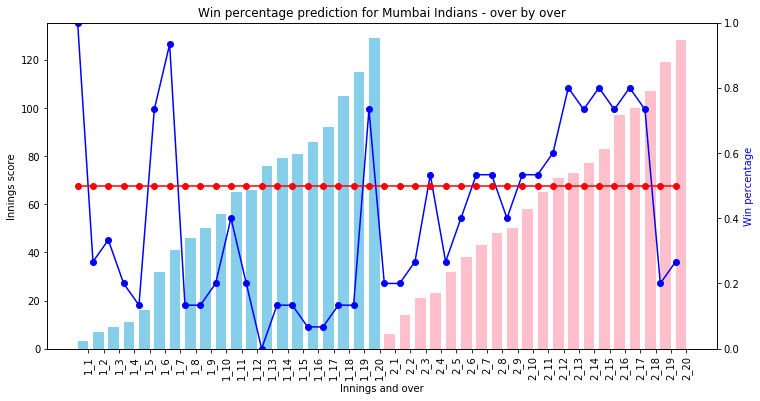

In [18]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=['skyblue']*20 + ['pink']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Mumbai Indians - over by over")

ax2.plot(ind-0.35, np.array(out_df['predictions']), color='b', marker='o')

ax2.plot(ind-0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

Light Blue Bars denote the overs played by Mumbai Indians. Baby Pink Bars denote the overs batted by Rising Pune Super-Giants.  

Red line represents the equal win probability and dark blue line represents the win probability of MI at the end of each over. 

While an overall trend can be seen while plotting our win probability v/s cumulative runs scored by both the teams, it's nothing too profound and probably poor data visualisation. So we look to runs scored in each over where the inferences get more exciting. 
 
So let us look at the same graph by using the number of runs scored in that over in place of overall runs.

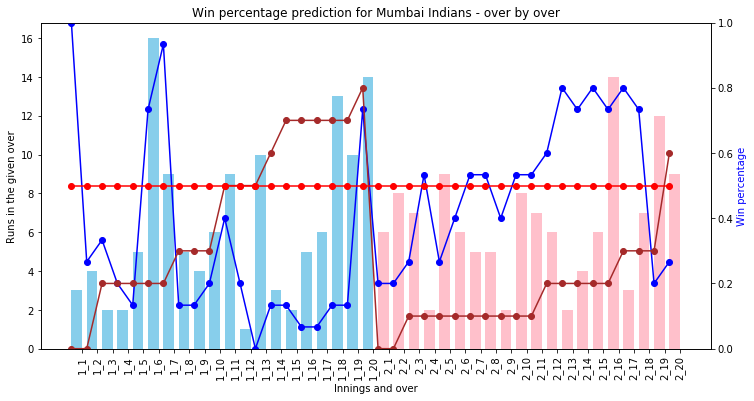

In [19]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['skyblue']*20 + ['pink']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Mumbai Indians - over by over")

ax2.plot(ind-0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind-0.35, np.array(out_df['innings_wickets']/10), color='brown', marker='o')
ax2.plot(ind-0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

We have also added the wicket plot to better analyse the win probability variation while the runs scored per over varies. 

We can see a direct correlation between the run scored in an over and the affect it has on the odds. We make predictions right untill the beginning of the 20th Over since there's no point in predicting the outcome after the match has finished.

###### Analysing win probability of Mumbai while Mumbai were batting from a microscope is probably moot because, while an increasing or decreasing trend for win probability can be noted for a good or a bad over for MI respectively, the value doesn't signify that much, hence we require to put the SRH innings through the microscope.

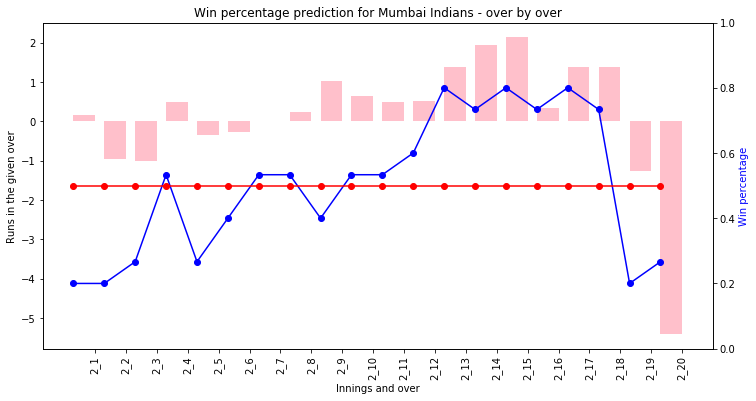

In [20]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df[20:]['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df[20:]['runrate_diff']*(-1)), width=width, color=['pink']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Mumbai Indians - over by over")

ax2.plot(ind-0.35, np.array(out_df[20:]['predictions']), color='b', marker='o')
#ax2.plot(ind-0.35, np.array(out_df['innings_wickets']/10), color='brown', marker='o')
ax2.plot(ind-0.35, np.array([0.5]*20), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

Now this is the best visualization we have come up with. This figure plots difference in run-rates between MI and RPS while we can visibly see the clear cause & effect relationship between the said parameter and the winning probability of Mumbai. 

**Note: Our model is not wrong to predict a meagre 0.4 win probability for Mumbai in the beginning of 20th Over. RPS had 7 wickets in hand going into the second last over. While 23 runs were required in the last 2 overs, RPS scored a whopping 12 runs which slid Mumbai's winning probability down too low. While Mumbai had the momentum from 10th Over onwards, RPS had it now and coudl've clearly taken the game home. However, 9 runs and 3 wickets and 6 balls later, Mumbai were declared winners in a historic nail-biting 1-run win**

**We can Infer from this the following things: **
1. It's the safest to bet on the team that's on the upper foot during 2nd Innings Mid-Overs. 
2. The Death Overs are highly unpredictable and it's safer to not bet on the basis of those results. 
3. While wickets are important parameter throughout the match, the winning probability over 20-overs is more dependant on run-rate than anything else. 